# Plot uDaq data from Dec_26_2024 firmware

## version: 2025-06-24

### changelog
 - select bin files like *bin.0, *bin.1, etc.
 - tweaked for new Dec_26_2024 udaq firmware
 - add pickle loading option

In [1]:
%matplotlib inline
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import datetime
import json
import pickle

sys.path.append('./modules')
from udaq_decoder_subruns import *
from utils import *
from log_parser import *
from fitting_funcs import *


In [2]:
# set "user" and "run"

user = './data/taxi01'
#------------------------------------
run = 2149






# read in the run info
#==================================================================
runNum = str(run).zfill(7)
path = user+'/run_'+runNum

if not os.path.exists(path):
    print('run dir not found --> {0}'.format(path))

logfiles = sorted(glob.glob(os.path.join(path, '*info.txt')))
info = None
for logfile in logfiles:
    info = getSpoolInfo(logfile, info)

channels = info['channels']
YEAR = int(info['date'].split('-')[0])

#channels = [1]
for chan in channels:
    #print(info[str(chan)])
    cinfo = info[str(chan)]
    print('Chan-{0}  hv = {1}  disc = {2}  duration = {4}  events = {3}  '
          'trigrate = {5}  temp = {6}C  lbmo = {7}'
          .format(chan, cinfo['voltage'], cinfo['threshold'], 
                  cinfo['counts'], cinfo['duration'], cinfo['trigrate'], 
                  round(cinfo['temperature'][1],1), cinfo['overflows']))


Chan-1  hv = 2620  disc = 1392  duration = 121.1  events = 49250  trigrate = 406.8  temp = 22.6C  lbmo = 0
Chan-2  hv = 2620  disc = 1398  duration = 121.1  events = 55785  trigrate = 460.7  temp = 23.4C  lbmo = 0
Chan-3  hv = 2620  disc = 1392  duration = 121.1  events = 48962  trigrate = 404.4  temp = 23.4C  lbmo = 0
Chan-4  hv = 2620  disc = 1394  duration = 121.2  events = 54969  trigrate = 453.7  temp = 23.1C  lbmo = 0
Chan-5  hv = 2620  disc = 1394  duration = 121.2  events = 51147  trigrate = 422.1  temp = 23.1C  lbmo = 0
Chan-6  hv = 2620  disc = 1394  duration = 121.1  events = 53401  trigrate = 440.8  temp = 23.3C  lbmo = 0
Chan-7  hv = 2620  disc = 1405  duration = 121.1  events = 60676  trigrate = 500.9  temp = 22.8C  lbmo = 0
Chan-8  hv = 2620  disc = 1398  duration = 121.1  events = 57960  trigrate = 478.7  temp = 22.7C  lbmo = 0


In [3]:
### decode the hit buffer

use_pickle = 0

# decode options
HV_CORR = 0
COBS    = 0
DEBUG   = 0

picklefile = os.path.join(path, 'run_{0}_alldata.pkl'.format(runNum))
if os.path.exists(picklefile) and use_pickle:
    print('loading pickle file\n')
    with open(picklefile, 'rb') as pfile:
        alldata = pickle.load(pfile)
else:
    alldata = {}
    for chan in channels:
        runfiles = sorted(glob.glob(os.path.join(path, 'run_{0}_chan-{1}.bin*'.format(runNum, chan))))
        if not runfiles:
            print('WARNING: no binary files not found for run {0} chan-{1}'.format(runNum, chan))
            continue
        print('DECODING: chan-{0}'.format(chan))
        print('-----------------------------------------------')
        data = payloadReader(runfiles, hv_corr=HV_CORR, cobs_decode=COBS, debug=DEBUG)
        alldata[str(chan)] = data
        print()
        #break
        
    # save decoded data to pickle only if data exists
    if alldata:
        print('saving pickle file \n')
        with open(picklefile, 'wb') as pfile:
            pickle.dump(alldata, pfile)

channels = sorted([int(x) for x in alldata.keys()])

for chan in channels:

    duration = livetime(alldata[str(chan)])
    info[str(chan)]['good_duration'] = round(duration, 1)
    events = len(alldata[str(chan)])
    info[str(chan)]['good_events'] = events
    if duration and events:
        rate = events / duration
    else:
        rate = -1
    info[str(chan)]['good_rate'] = round(rate, 1)
    
    print()
    print('run = {0}  chan = {1}  duration = {2} sec  events = {3}  rate = {4} Hz'
          .format(runNum, chan, info[str(chan)]['good_duration'], 
                  info[str(chan)]['good_events'], info[str(chan)]['good_rate']))


print('\nDONE\n')



DECODING: chan-1
-----------------------------------------------
INFO: Start of Stream flagged
INFO: End of Stream flagged

DECODING: chan-2
-----------------------------------------------
INFO: Start of Stream flagged
INFO: End of Stream flagged

DECODING: chan-3
-----------------------------------------------
INFO: Start of Stream flagged
INFO: End of Stream flagged

DECODING: chan-4
-----------------------------------------------
INFO: Start of Stream flagged
INFO: End of Stream flagged

DECODING: chan-5
-----------------------------------------------
INFO: Start of Stream flagged
INFO: End of Stream flagged

DECODING: chan-6
-----------------------------------------------
INFO: Start of Stream flagged
INFO: End of Stream flagged

DECODING: chan-7
-----------------------------------------------
INFO: Start of Stream flagged
INFO: End of Stream flagged

DECODING: chan-8
-----------------------------------------------
INFO: Start of Stream flagged
INFO: End of Stream flagged

saving p

In [4]:
# some options for what to show
hit_times        = 1
plot_hists       = 1
find_gain        = 0
fit_mip          = 1
print_gain_ratio = 0
plot_gain_ratio  = 0

# some dependence
if plot_gain_ratio: print_gain_ratio = 1
if plot_hists or find_gain or fit_mip or print_gain_ratio or plot_gain_ratio:
    do_stuff = 1
else:
    do_stuff = 0


first hit = 2025-06-25 18:43:33.967772
last hit  = 2025-06-25 18:45:35.141810


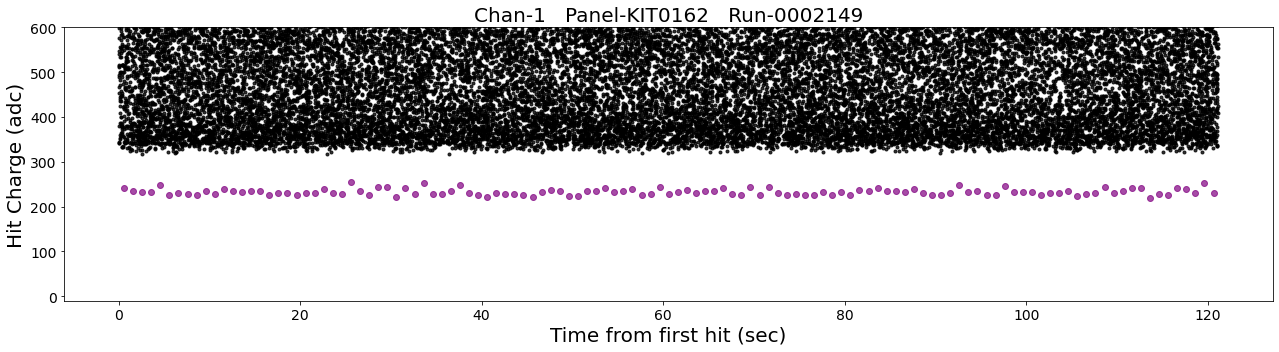

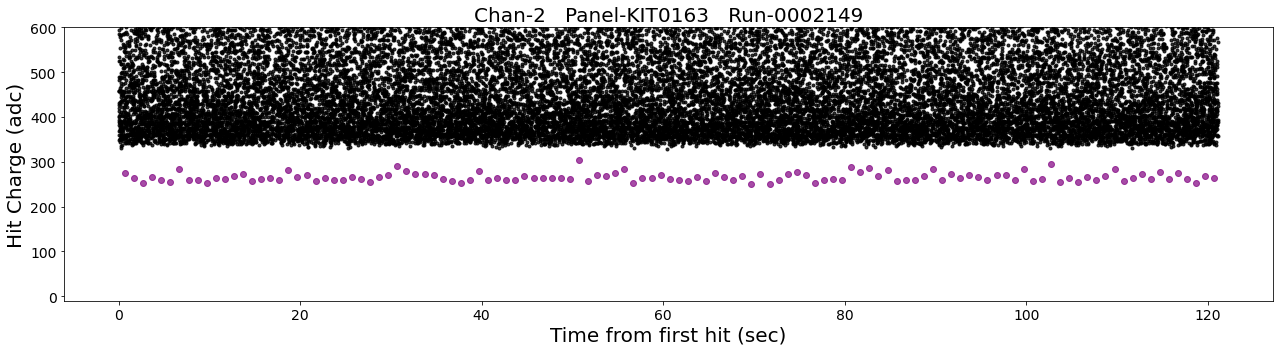

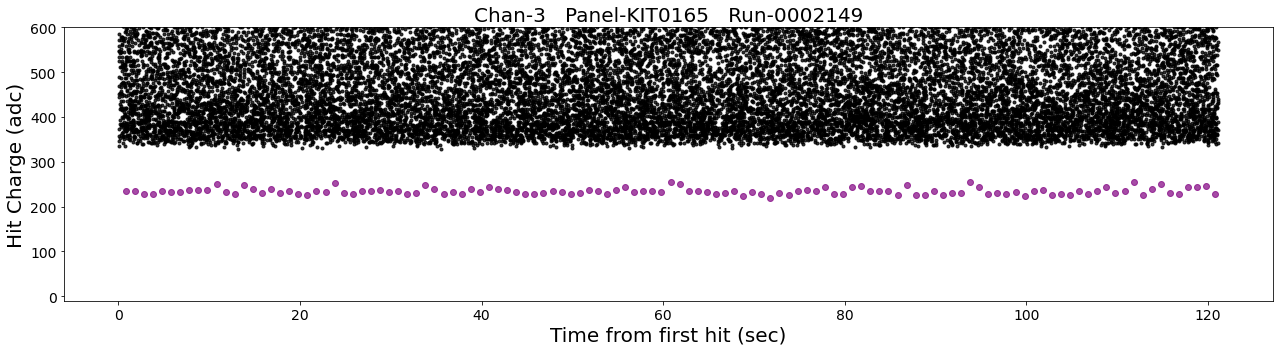

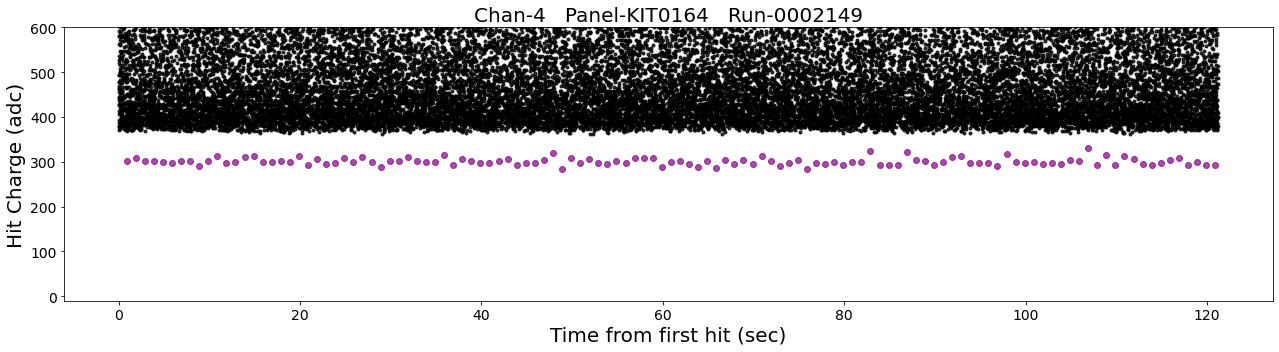

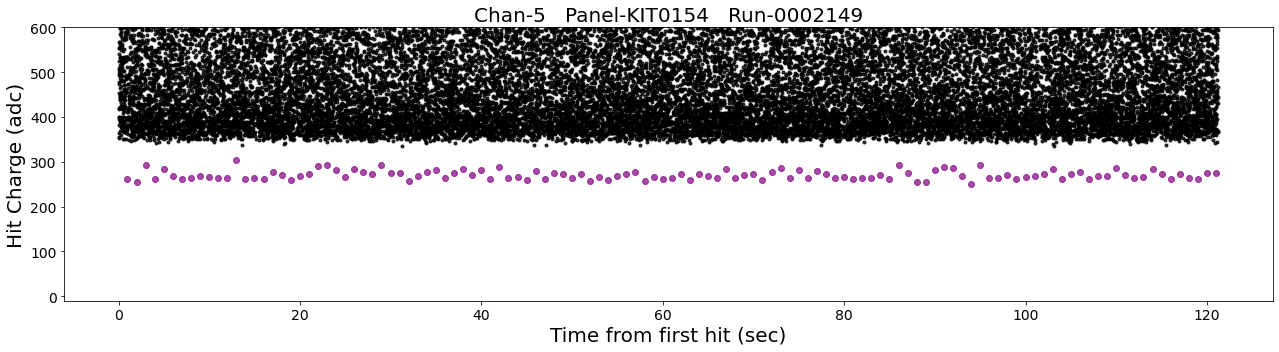

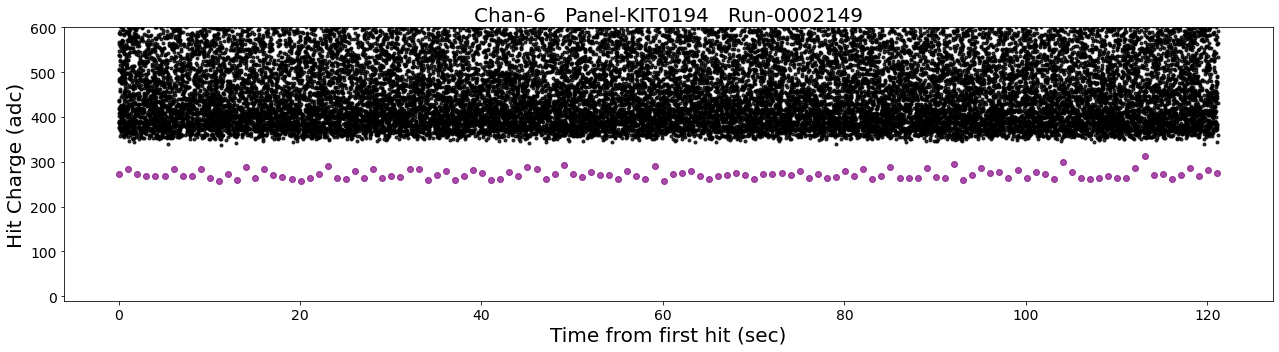

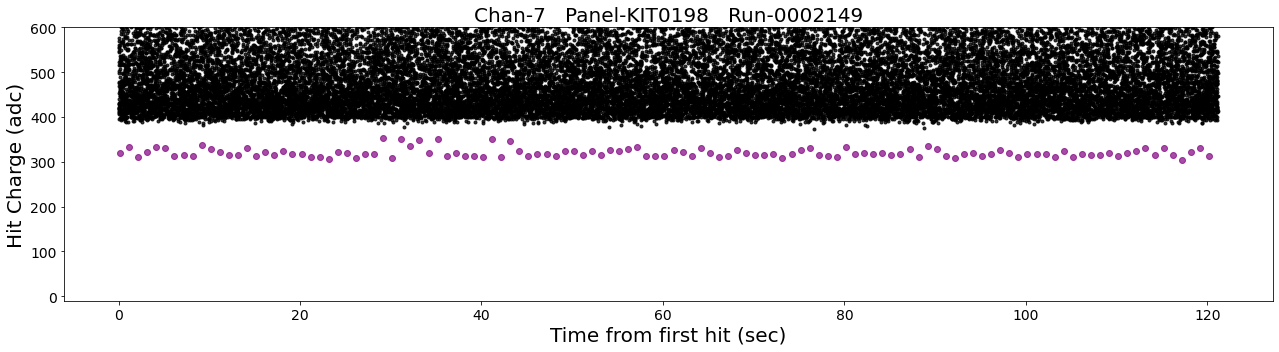

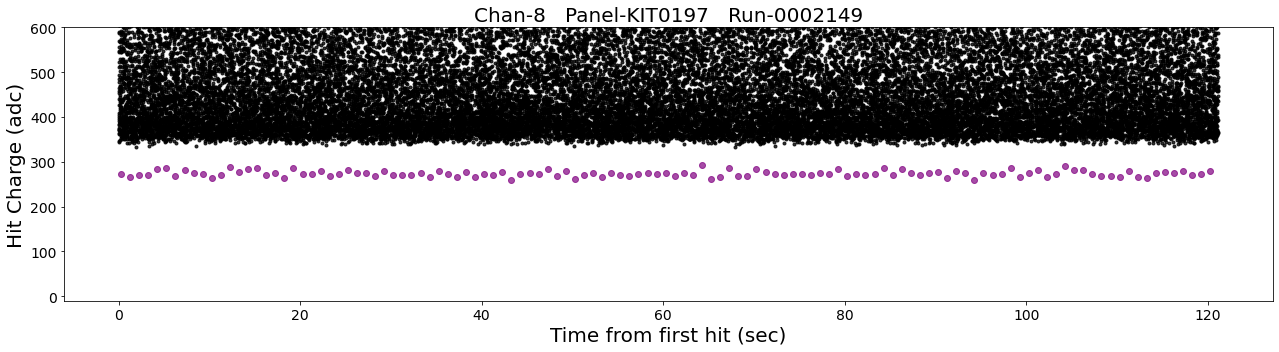

In [5]:
### plot charge vs time
if hit_times:

    # find min start time
    time0=[]
    time1=[]
    for chan in channels:
        try:
            time0.append(alldata[str(chan)][0][0])
            time1.append(alldata[str(chan)][-1][0])
        except: continue

    #print time0
    time0 = np.min(time0)
    time1 = np.max(time1)
    #print('start =', time0)
    #print('stop  =', time1)

    start_time = datetime.datetime(year=YEAR, month=1, day=1) + datetime.timedelta(seconds=time0)
    print('first hit =', start_time)
    stop_time = datetime.datetime(year=YEAR, month=1, day=1) + datetime.timedelta(seconds=time1)
    print('last hit  =', stop_time)
    #good_time = round((stop_time - start_time).total_seconds(), 1)
    #print('run time  =', good_time)
    
    for chan in channels:
        hittimes = []
        cputimes = []
        hits = []
        cpus = []
        chargestamps = alldata[str(chan)]
        for i in range(len(alldata[str(chan)])):
            if alldata[str(chan)][i][4] == 0:
                hittimes.append(alldata[str(chan)][i][0]-time0)
                hits.append(alldata[str(chan)][i][1]) # high gain
                #hits.append(chargestamps[i][2]) # med gain
                #hits.append(chargestamps[i][3]) # low gain
            else:
                cputimes.append(alldata[str(chan)][i][0]-time0)
                cpus.append(alldata[str(chan)][i][1]) # high gain
                #cpus.append(alldata[str(chan)][i][2]) # med gain
                #cpus.append(alldata[str(chan)][i][3]) # low gain
        
        fig, ax = plt.subplots(1, 1, figsize=(18, 5), facecolor='w', edgecolor='k')
        plt.sca(ax)

        plt.plot(hittimes, hits, ls='', marker='.', color='black', alpha=0.8)
        plt.plot(cputimes, cpus, ls='', marker='o', color='purple', alpha=0.7)

        plt.title('Chan-'+str(chan)
                  +'   Panel-'+str(get_panel(info[str(chan)]['uid']))
                  +'   Run-'+str(runNum)
                  , size=20)

        plt.xlabel('Time from first hit (sec)', size=20)
        plt.ylabel('Hit Charge (adc)', size=20)
        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.tight_layout()
        #plt.legend(fontsize=24, loc=1);
        #plt.xlim(-1, 10);
        plt.ylim(-10, 600)


In [6]:
### build the histograms as lists
if do_stuff:
    
    hists = {}
    peds = {}
    for chan in channels:
        hists[str(chan)] = []
        peds[str(chan)] = []
        #for a in [1,2,3,5]:
        for a in [1,2,3]:
            adc = np.zeros(4096)
            ped = np.zeros(4096)
            for hit in alldata[str(chan)]:
                ### select a time window of hits
                #dt = hit[0]-time0
                #if dt > 60: continue
                #if dt > 500: continue

                ### 0 for hits - 1 for pedestal
                if hit[4] == 0: adc[int(hit[a])] += 1
                if hit[4] == 1: ped[int(hit[a])] += 1

            # clear saturation bin
            adc[-1] = 0
            ped[-1] = 0
            
            hists[str(chan)].append(adc)
            peds[str(chan)].append(ped)


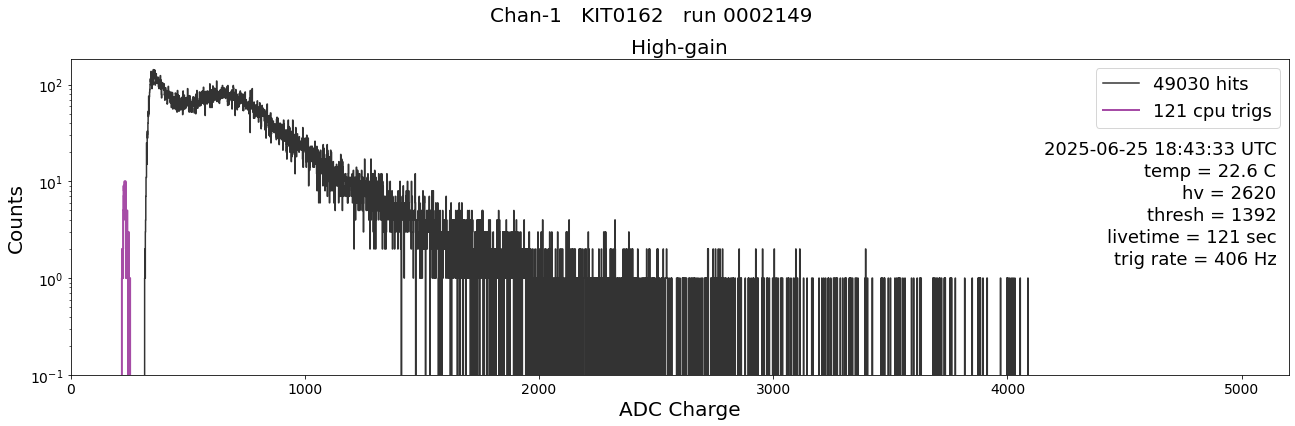

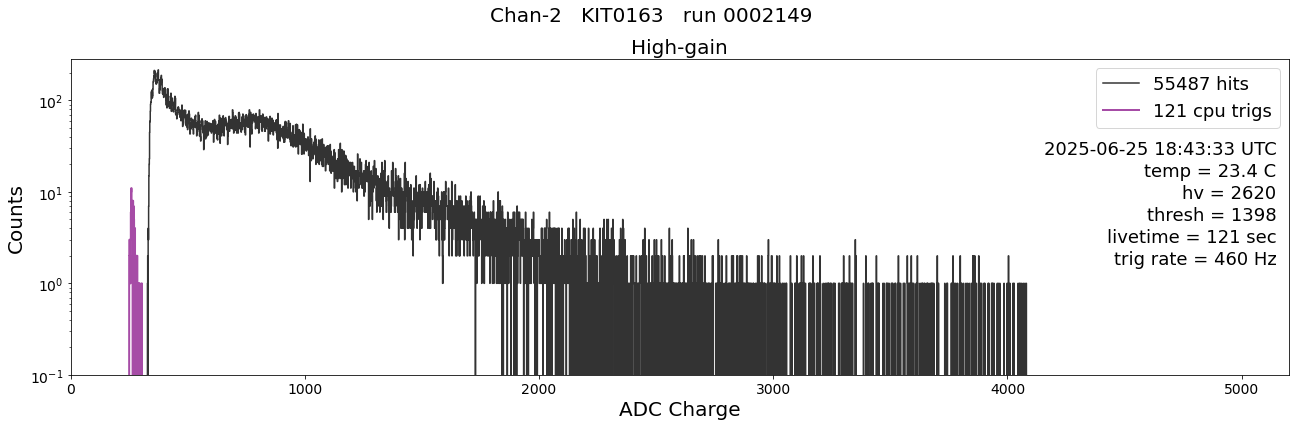

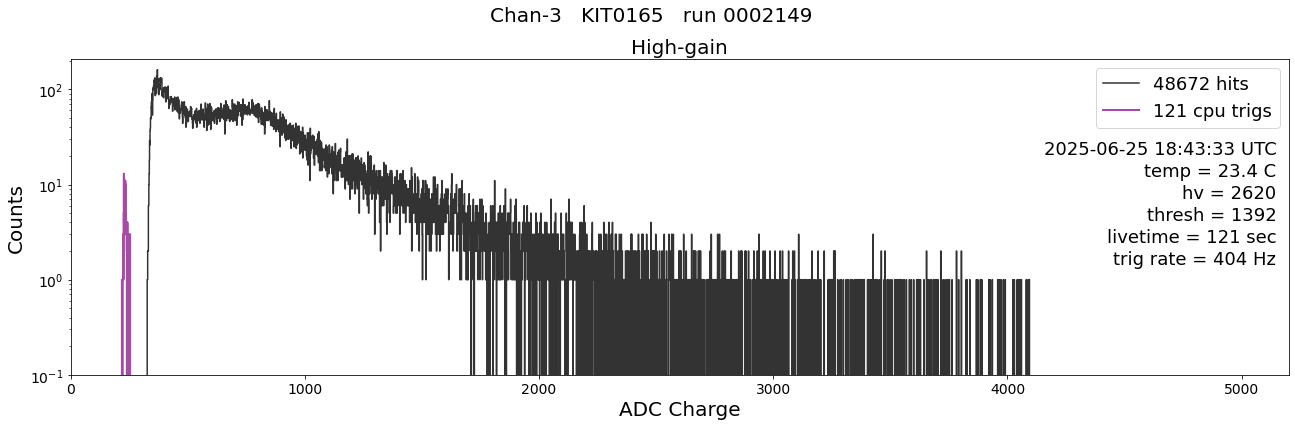

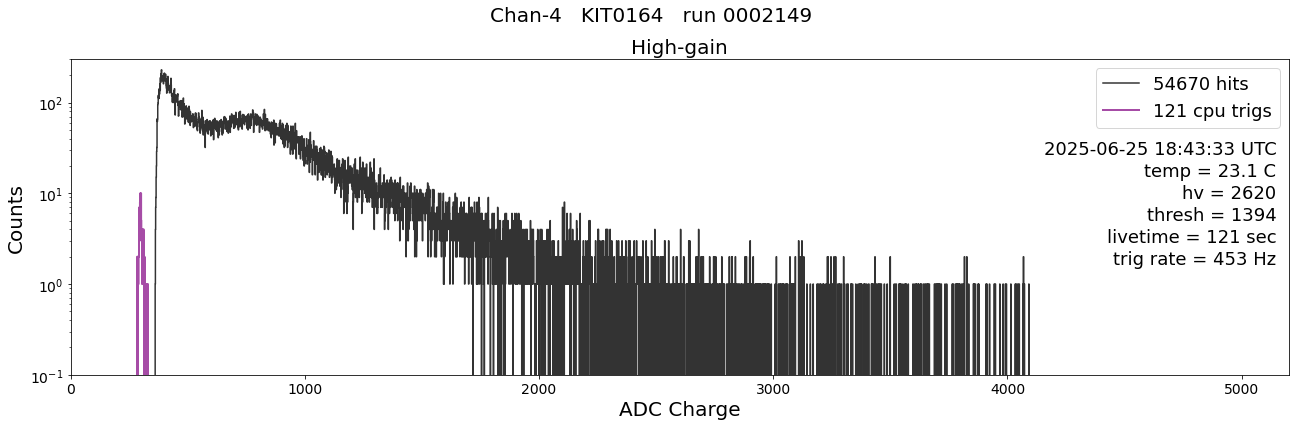

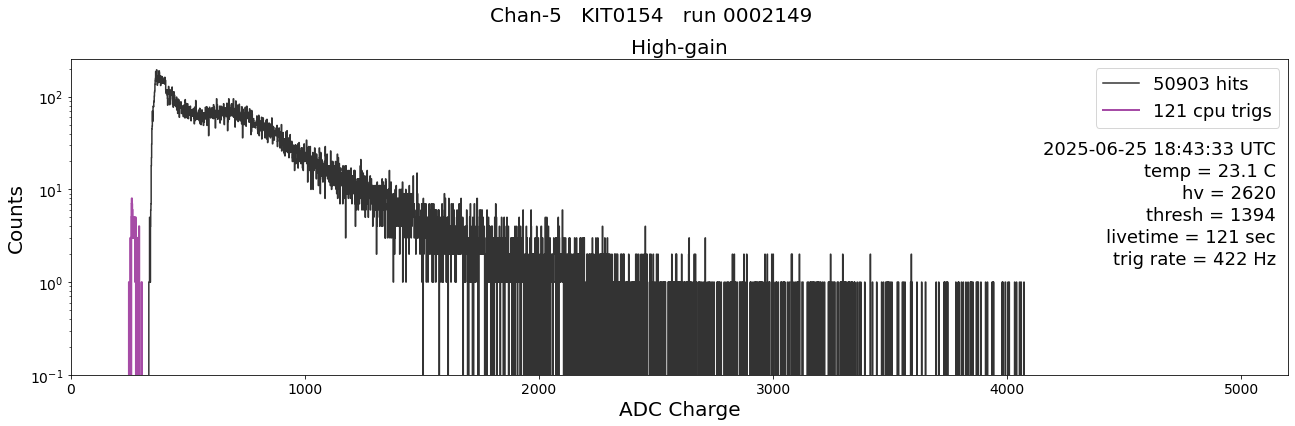

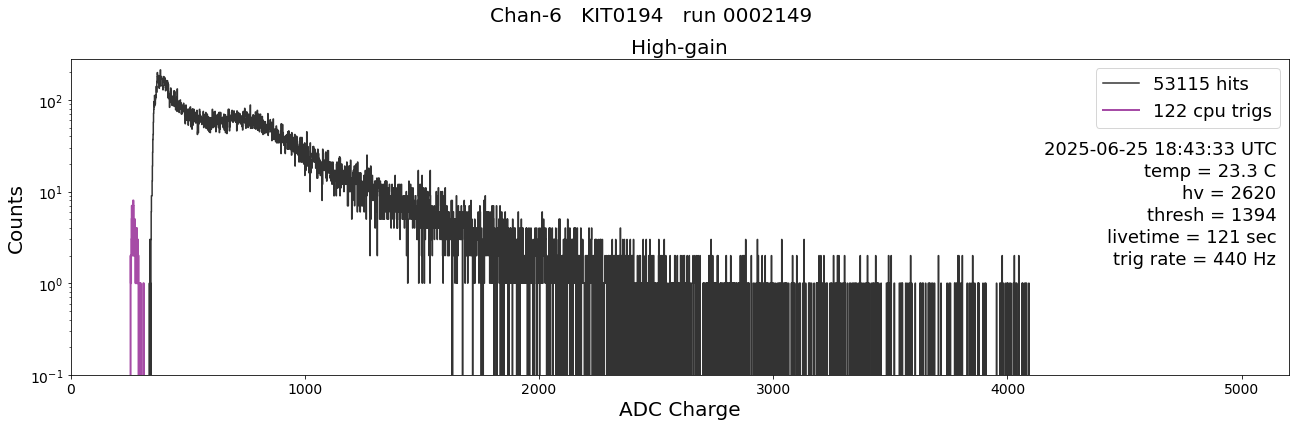

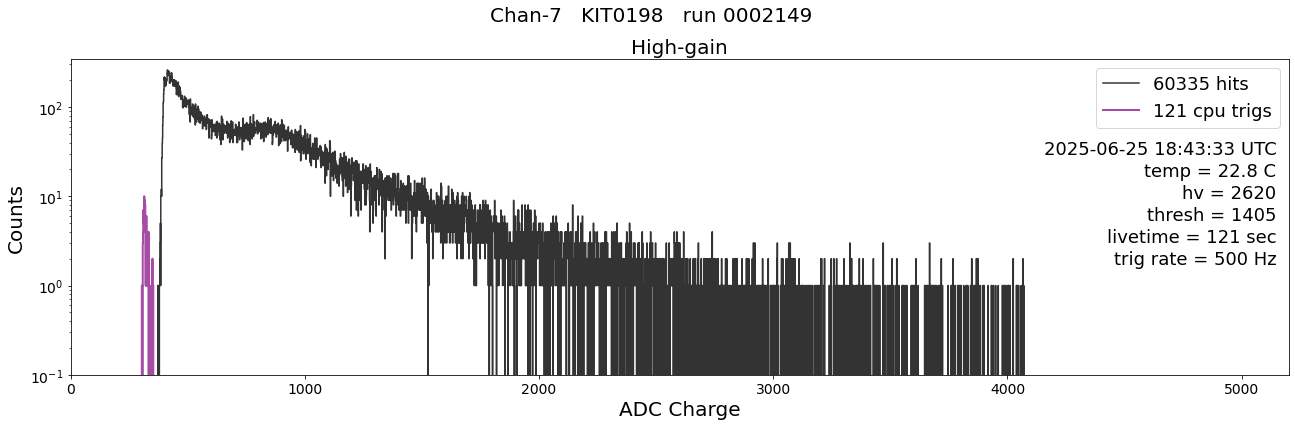

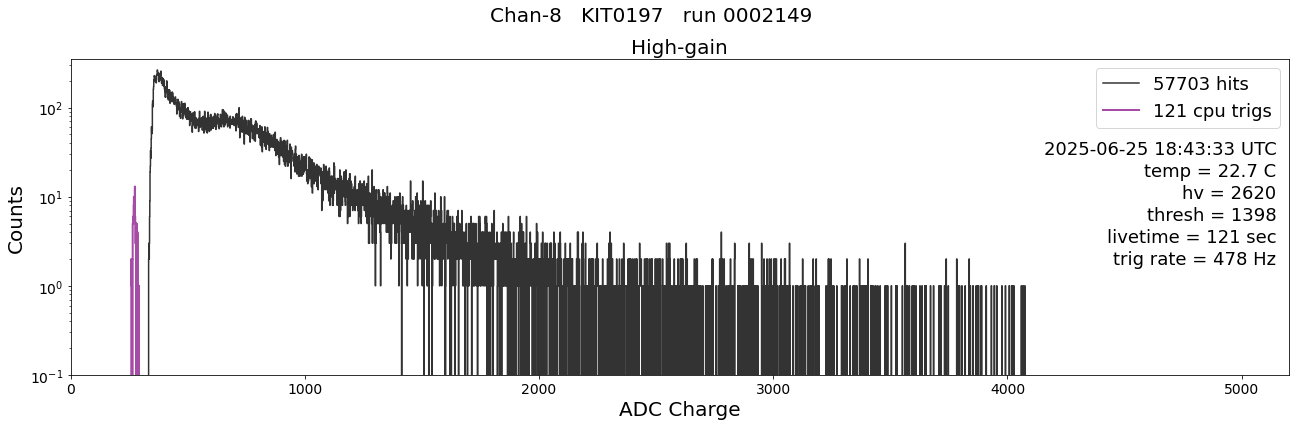

In [7]:
### plot the charge histograms
if plot_hists:
    
    save_plots = 0
    
    plot_text = makeText(info)

    # 0 - hi gain
    # 1 - med gain
    # 2 - low gain
    # 3 - ToT

    #adcs = [0,1,2,3]
    #adcs = [0,1,2]
    adcs = [0]

    labels = ['High-gain', 'Med-gain', 'Low-gain', 'ToT']
    #labels = ['ADC-0', 'ADC-2', 'ADC-12', 'ToT']
    yscale = ['log', 'log', 'log', 'log']
    xlim = [4200, 4200, 4200, 3000]
    #xlim = [4000, 400, 100, 4200]

    for i, chan in enumerate(channels):

        fig, ax = plt.subplots(1, len(adcs), figsize=(18, 6), facecolor='w', edgecolor='k')
        fig.suptitle('Chan-'+str(chan)
                      +'   '+get_panel(info[str(chan)]['uid'])
                      +'   run '+str(runNum)
                     , size=20)

        for a in range(len(adcs)):

            if len(adcs) > 1: axs = ax[a]
            else: axs = ax
            plt.sca(axs)
            
            plt.plot(range(len(hists[str(chan)][adcs[a]])), 
                     hists[str(chan)][adcs[a]], 
                     color='black', alpha=0.8,
                     ls='-', 
                     drawstyle='steps',
                     label=str(int(sum(hists[str(chan)][adcs[a]])))+' hits'
                    )

            plt.plot(range(len(peds[str(chan)][adcs[a]])), 
                     peds[str(chan)][adcs[a]],
                     color='purple', alpha=0.7, 
                     ls='-',
                     drawstyle='steps',
                     linewidth=2,
                     label=str(int(sum(peds[str(chan)][adcs[a]])))+' cpu trigs'
                    )

            plt.title(labels[a], size=20)

            # add run info as text to plot
            # just in high gain plot
            # only if plotting just high gain
            if a == 0 and len(adcs) == 1:
                xlim[0] = 5200
                if str(chan) in plot_text:
                    y = 0.7
                    for mytext in plot_text[str(chan)]:
                        plt.text(0.99,
                                 y,
                                 mytext,
                                 fontsize=18,
                                 horizontalalignment='right',
                                 transform=axs.transAxes)
                        y -= 0.07


            plt.xlabel('ADC Charge', size=20)
            plt.ylabel('Counts', size=20)
            plt.tick_params(axis='both', which='major', labelsize=14)
            plt.tight_layout()
            plt.legend(fontsize=18, loc='upper right')
            #plt.xlim(0, 1500)
            plt.xlim(0, xlim[a])
            plt.yscale(yscale[a])
            plt.ylim(0.1)


            # just save the high gain plot
            if a == 0 and save_plots:
                if not os.path.exists('./plots/'+user):
                    os.makedirs('./plots/'+user)
                plt.savefig('./plots/'+user+'/'
                            +'run'+str(runNum)
                            +'_chan-'+str(chan)
                            +'_'+get_panel(info[str(chan)]['uid'])
                            +'_spooled'
                            #+'chan-'+str(chan)
                            #+'_adc-'+str(a)
                            +'.png'
                            , bbox_inches='tight')
            
            # save for quick checks
            #plt.savefig('./chan-{0}'.format(chan), bbox_inches='tight')



In [8]:
### measure the gain via fft
if find_gain:
    
    for chan in channels:
        print('\nChan-{0}'.format(chan))
        gaininfo = findGain(hist=hists[str(chan)][0], 
                          title='Chan-{0}'.format(chan),
                          #save='chan-{0}_gain'.format(chan),
                          plot=True,
                          debug=False)
        
        print('gain = {0} [{1}]'.format(round(gaininfo['gain'],1), gaininfo['good_gain']))
        if not gaininfo['good_gain']:
            print('  --> ', gaininfo['bad_gain_reasons'])



Fitting Chan-1

Fitting Chan-2

Fitting Chan-3

Fitting Chan-4

Fitting Chan-5

Fitting Chan-6

Fitting Chan-7

Fitting Chan-8


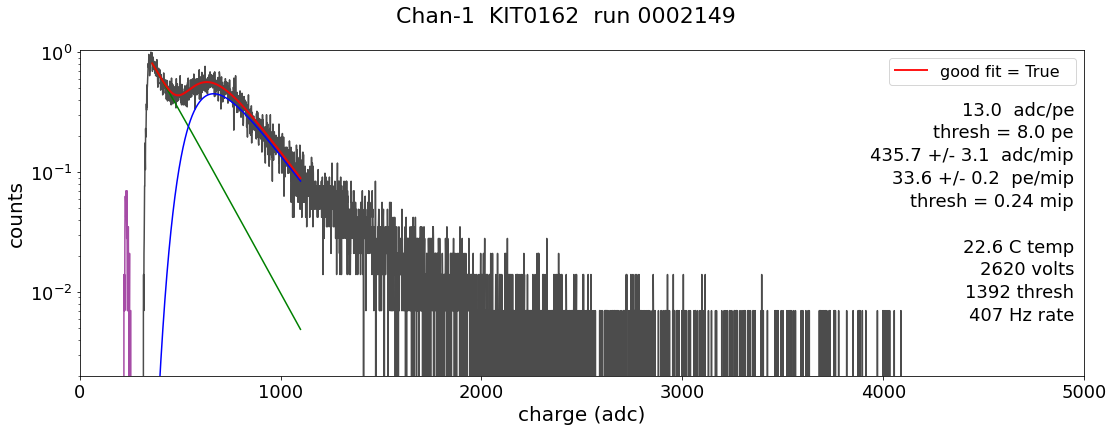

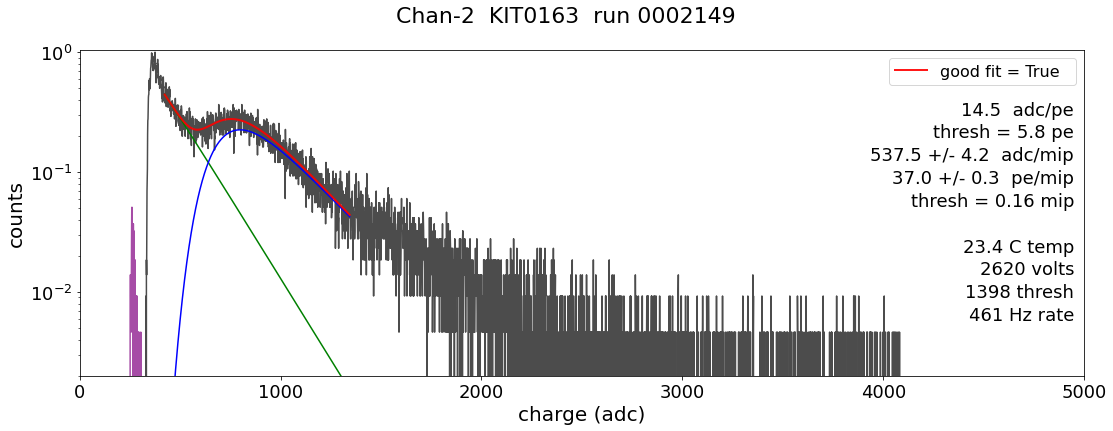

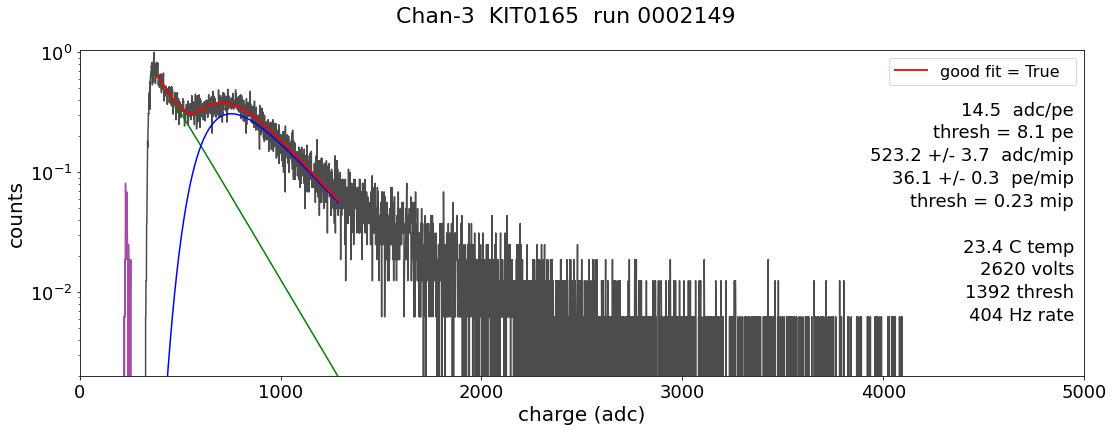

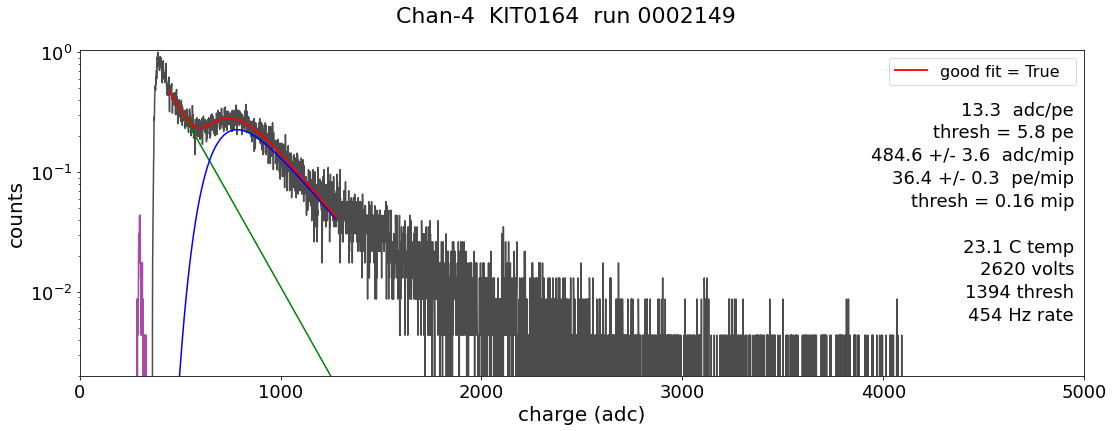

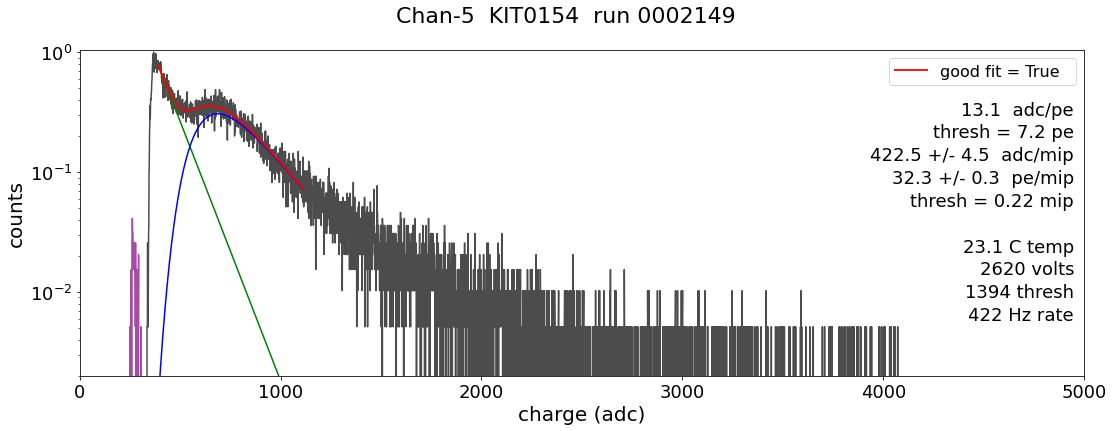

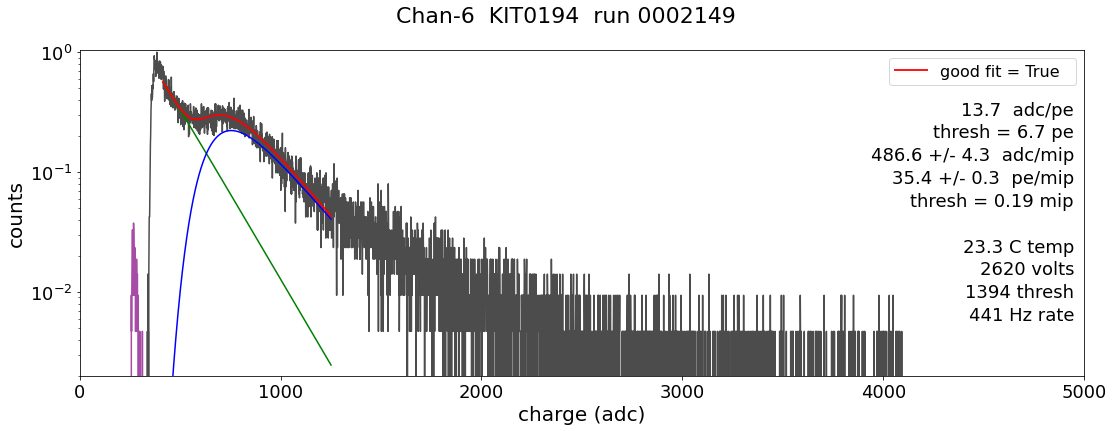

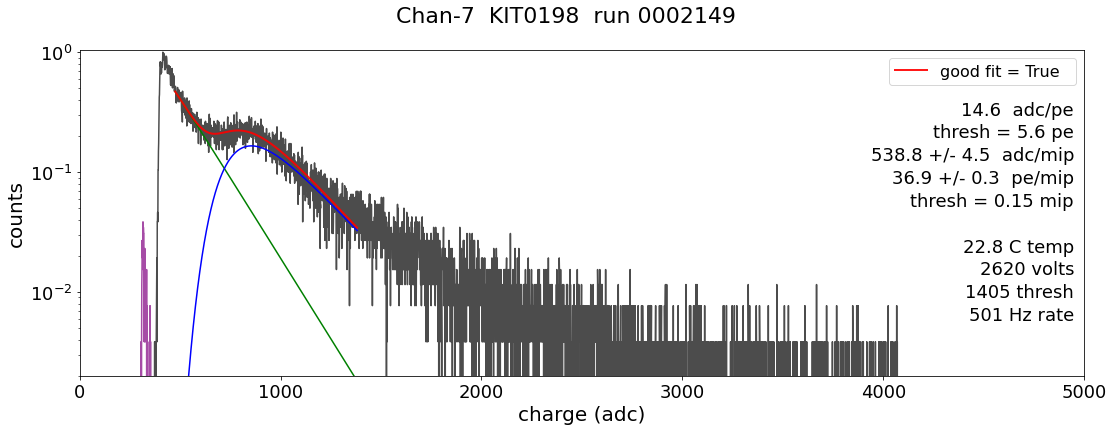

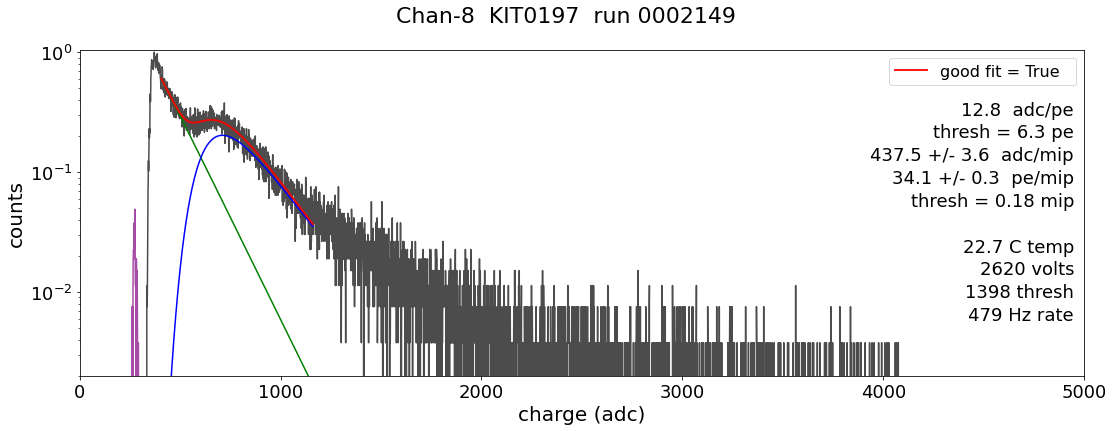

In [9]:
# fit the MIP
if fit_mip:
    
    fit_info = {}
    for chan in channels:
    #for chan in [3]:
        print('\nFitting Chan-{0}'.format(chan))
        #for fitfunc in [adcFitMIP, peFitMIP]:
        #for fitfunc in [adcFitMIP]:
        for fitfunc in [peFitMIP]:
            fit_info[str(chan)] = fitfunc(hist=hists[str(chan)][0], 
                                     ped=peds[str(chan)][0], 
                                     config=info[str(chan)],
                                     title='Chan-{0}  {1}  run {2}'
                                          .format(chan, get_panel(info[str(chan)]['uid']), runNum), 
                                     #save='chan-{0}_mip-fit'.format(chan),
                                     plot=True,
                                     debug=False)


In [10]:
### check relative adc gains
if print_gain_ratio:
    
    gain1 = {}
    gain2 = {}
    gain3 = {}
    for chan in channels:
        ### get pedestals
        ped = [0,0,0]
        for a in [0,1,2]:
            ped[a] = np.argmax(peds[str(chan)][a])
        #print ped
        gain1[str(chan)] = []
        gain2[str(chan)] = []
        gain3[str(chan)] = []
        for hit in alldata[str(chan)]:
            # only hits (not cpu triggers)
            if hit[4] != 0: continue
            # pedestal must be greater than 1
            if ped[0]<=1 or ped[1]<=1 or ped[2]<=1: continue
            # hit charge must be greater than 1
            if hit[1]<=1 or hit[2]<=1 or hit[3]<=1: continue
            # hit - ped must have some space
            if (hit[1]-ped[0])<=20 or (hit[2]-ped[1])<=10 or (hit[3]-ped[2])<=5: continue
            # hi-gain and med-gain charge must be less than 4000
            if hit[1]<4000 and hit[2]<4000:
                gain1[str(chan)].append((hit[1]-ped[0])/float(hit[2]-ped[1]))
            # med-gain and low-gain charge must be less than 4000
            if hit[2]<4000 and hit[3]<4000:
                gain2[str(chan)].append((hit[2]-ped[1])/float(hit[3]-ped[2]))
            # hi-gain and low-gain charge must be less than 4000
            if hit[1]<4000 and hit[3]<4000:
                gain3[str(chan)].append((hit[1]-ped[0])/float(hit[3]-ped[2]))
                
        print('Chan-{0}  high/med gain = {1} +/- {2}'
              .format(chan, round(np.mean(gain1[str(chan)]),1), 
                      round(np.std(gain1[str(chan)]),1)))
        print('Chan-{0}  med/low gain  = {1} +/- {2}'
              .format(chan, round(np.mean(gain2[str(chan)]),1), 
                      round(np.std(gain2[str(chan)]),1)))
        print('Chan-{0}  high/low gain = {1} +/- {2}'
              .format(chan, round(np.mean(gain3[str(chan)]),1), 
                      round(np.std(gain3[str(chan)]),1)))
        # estimate saturation point (in mips) at low-gain bin 4000
        sat_adc = 4000
        if 'adcPerMIP' in fit_info[str(chan)]:
            sat_mip = (sat_adc - ped[2]) / (fit_info[str(chan)]['adcPerMIP'] / np.mean(gain3[str(chan)]))
            print('Chan-{0}  low-gain sat. = {1} MIP (at {2} adc)'.format(chan, round(sat_mip,1), sat_adc))
        
        print()


In [11]:
# plot the gains to see how they look
if plot_gain_ratio:
    
    for chan in channels:
        fig, ax = plt.subplots(1, 2, figsize=(18, 6), facecolor='w', edgecolor='k')
        for x, chgain in enumerate([gain1[str(chan)], gain2[str(chan)]]):
            plt.sca(ax[x])

            if x==0:
                label = 'high/med gain'
                legtx = 'upper left'
            else:
                label = 'med/low gain'
                legtx = 'upper right'

            ax[x].hist(chgain,
                     range=[0, 35], 
                     bins=35,
                     color='black', alpha=0.8,
                     #ls='-', 
                     #drawstyle='steps',
                     label=label
                    );
            ax[x].set_title('Chan-'+str(chan))
            ax[x].legend(loc=legtx, fontsize=16)
